In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.ensemble import IsolationForest
from functools import reduce
import sys

sys.path.append("../src")
from utils import *

In [3]:
pd.set_option("display.max_columns", None)

# 1). Exploratory data analysis

In [4]:
df = pd.read_csv("ecommerce_dataset.csv", sep=";")
df["datetime"] = pd.to_datetime(df["Timestamp"], unit="s")
df

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,Product Price,Product quantity,Product category,Environment,Device type,Browser family,User location,datetime
0,1460462764,NaN,NaN,0,Basket,Unknown,11.0,1.0,Medium Items,web,Desktop,safari,Inland,2016-04-12 12:06:04
1,1490572501,0c6205543f3f6a7e8082,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,edge,Outside,2017-03-26 23:55:01
2,1490572501,0c6205543f3f6a7e8082,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,edge,Outside,2017-03-26 23:55:01
3,1490572501,0c6205543f3f6a7e8082,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,Desktop,edge,Outside,2017-03-26 23:55:01
4,1490571486,0cd8953a90d837c045c9,NaN,0,Listing,Unknown,NaN,NaN,Packages,web,iPhone,mobile safari,Inland,2017-03-26 23:38:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400632,1481114381,e36784e0137f2d4a0664,NaN,0,Product,6b4a,20.0,1.0,Large Items,web,Desktop,chrome,Inland,2016-12-07 12:39:41
400633,1481110211,e36784e0137f2d4a0664,NaN,0,Product,6b4a,18.0,1.0,Large Items,web,Desktop,chrome,Inland,2016-12-07 11:30:11
400634,1486546342,a2ab4ae31eea5c201ad1,NaN,0,Product,6b4a,17.0,1.0,Large Items,web,Desktop,ie,Inland,2017-02-08 09:32:22
400635,1486546028,c3f6f7156450049389bd,NaN,1,Product,6b4a,18.0,1.0,Large Items,web,Desktop,safari,Inland,2017-02-08 09:27:08


In [5]:
for col in ["Product category", "Environment", "Device type", "User location",
           "Browser family", "Existing client"]:
    print(col)
    print(df[col].value_counts(dropna=False))
    print("\n")

Product category
Product category
Packages        187194
Small Items     125783
Medium Items     61981
Large Items      25679
Name: count, dtype: int64


Environment
Environment
web            359318
app_android     41319
Name: count, dtype: int64


Device type
Device type
Desktop                 297419
Unknown                  41319
iPhone                   25143
Android - Smartphone     13875
iPad                     12768
Android - Tablet          5340
Mobile - Other            4773
Name: count, dtype: int64


User location
User location
Inland     311988
Outside     47041
Unknown     41608
Name: count, dtype: int64


Browser family
Browser family
chrome                         146311
safari                          69706
firefox                         47538
other                           41335
mobile safari                   35246
ie                              19231
edge                            15285
chrome mobile                   12514
facebook                         3918

# 2). Granularity analysis

## 2). 1). Daily revenues

In [6]:
df_revenues = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_revenues["revenue"] = (
    df_revenues["price"] * 
    df_revenues["quantity"]
)

df_revenues["datetime"] = df_revenues["datetime"].dt.date 

full_date_range = pd.date_range(
    start=df_revenues.datetime.min(),
    end=df_revenues.datetime.max(),
    freq="D"
)

missing_dates = (
    full_date_range.difference(df_revenues.datetime)
)


df_revenues.head()

,Timestamp,User ID,Cross-device user ID,Existing client,Event type,Product ID,price,quantity,Product category,Environment,Device type,Browser family,User location,datetime,revenue
55,1490565487,55fb30957de5a149f5ff,2ee51dc1b4e4bc81f8bf,0,Sales,Unknown,62.0,1.0,Packages,web,Desktop,chrome,Inland,2017-03-26,62.0
140,1490561269,5b5be226c50dcc3ea630,NaN,0,Sales,Unknown,51.0,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26,51.0
260,1490557892,13d29a7b8ea7d4b7f751,7810f71660447164efa6,0,Sales,Unknown,4.0,1.0,Small Items,app_android,Unknown,other,Unknown,2017-03-26,4.0
261,1490557892,13d29a7b8ea7d4b7f751,7810f71660447164efa6,0,Sales,Unknown,4.0,1.0,Small Items,app_android,Unknown,other,Unknown,2017-03-26,4.0
365,1490554574,a89a7ecf9c0a6bee232c,dca71cc3e8432fbba939,1,Sales,Unknown,21.0,1.0,Packages,app_android,Unknown,other,Unknown,2017-03-26,21.0


In [7]:
df_revenues = df_revenues[["datetime", "revenue"]]

df_revenues = (
    df_revenues.groupby(["datetime"],
                       as_index=False).agg({"revenue":"sum"})
)

df_revenues.set_index("datetime", inplace=True)

for missing_date in missing_dates:
    df_revenues.loc[missing_date.date(), "revenue"] = np.nan

df_revenues.sort_index(inplace=True)

df_revenues.head()

,revenue
datetime,
2016-03-28,871.0
2016-03-29,533.0
2016-03-30,682.0
2016-03-31,431.0
2016-04-01,282.0


## 2). 2). Weekly revenues

In [8]:
df_revenues_weekly = df_revenues.copy(deep=True).reset_index()
df_revenues_weekly["datetime"] = pd.to_datetime(df_revenues_weekly["datetime"])
df_revenues_weekly.set_index("datetime", inplace=True)
df_revenues_weekly = df_revenues_weekly.resample("W-MON", label="left").agg({
    "revenue":["sum", "size"]
})
df_revenues_weekly = df_revenues_weekly.iloc[1:-1]
df_revenues_weekly = df_revenues_weekly[[("revenue", "sum")]]
df_revenues_weekly.columns = ["revenue"]
df_revenues_weekly.head()

,revenue
datetime,
2016-03-28,3752.0
2016-04-04,4158.0
2016-04-11,5662.0
2016-04-18,7414.0
2016-04-25,14807.0


## 2). 3). Monthly revenues

In [9]:
df_revenues_monthly = df_revenues.copy(deep=True).reset_index()
df_revenues_monthly["datetime"] = pd.to_datetime(df_revenues_monthly["datetime"])
df_revenues_monthly.set_index("datetime", inplace=True)
df_revenues_monthly = df_revenues_monthly.resample("MS").agg({
    "revenue":["sum", "size"]
})
df_revenues_monthly = (
df_revenues_monthly.iloc[1:-1]
)
df_revenues_monthly = df_revenues_monthly[[("revenue", "sum")]]
df_revenues_monthly.columns = ["revenue"]
df_revenues_monthly.head()

,revenue
datetime,
2016-04-01,32468.0
2016-05-01,24201.0
2016-06-01,19504.0
2016-07-01,17552.0
2016-08-01,21973.0


## 2). 4). Daily 7-day average revenues

In [10]:
df_revenues_avg = df_revenues.copy(deep=True)
df_revenues_avg["revenue"] = (
    df_revenues_avg["revenue"].rolling(window=7, min_periods=1).mean()
)
df_revenues_avg.head()

,revenue
datetime,
2016-03-28,871.000000
2016-03-29,702.000000
2016-03-30,695.333333
2016-03-31,629.250000
2016-04-01,559.800000


In [11]:
dict_granularity = {
    "daily":df_revenues,
    "rolling_avg":df_revenues_avg,
    "weekly":df_revenues_weekly,
    "monthly":df_revenues_monthly
}

dict_periods = {
    "daily":365,
    "rolling_avg":365,
    "weekly":52,
    "monthly":12
}

# 3). Evolution of the revenue during the year

## 3). 1). Levels

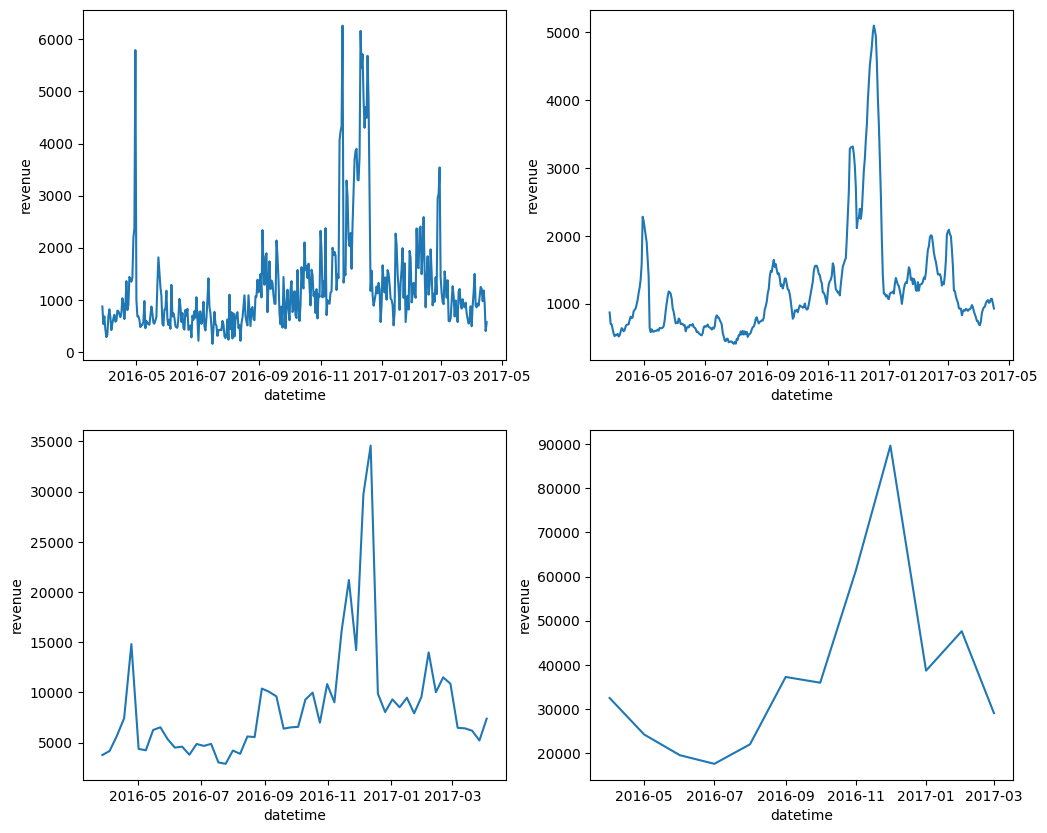

In [12]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
for i, granularity in enumerate(["daily", "rolling_avg", "weekly", "monthly"]):
    sns.lineplot(dict_granularity[granularity]["revenue"],
                ax=ax[i//2][i%2])

## 3). 2). Distributions

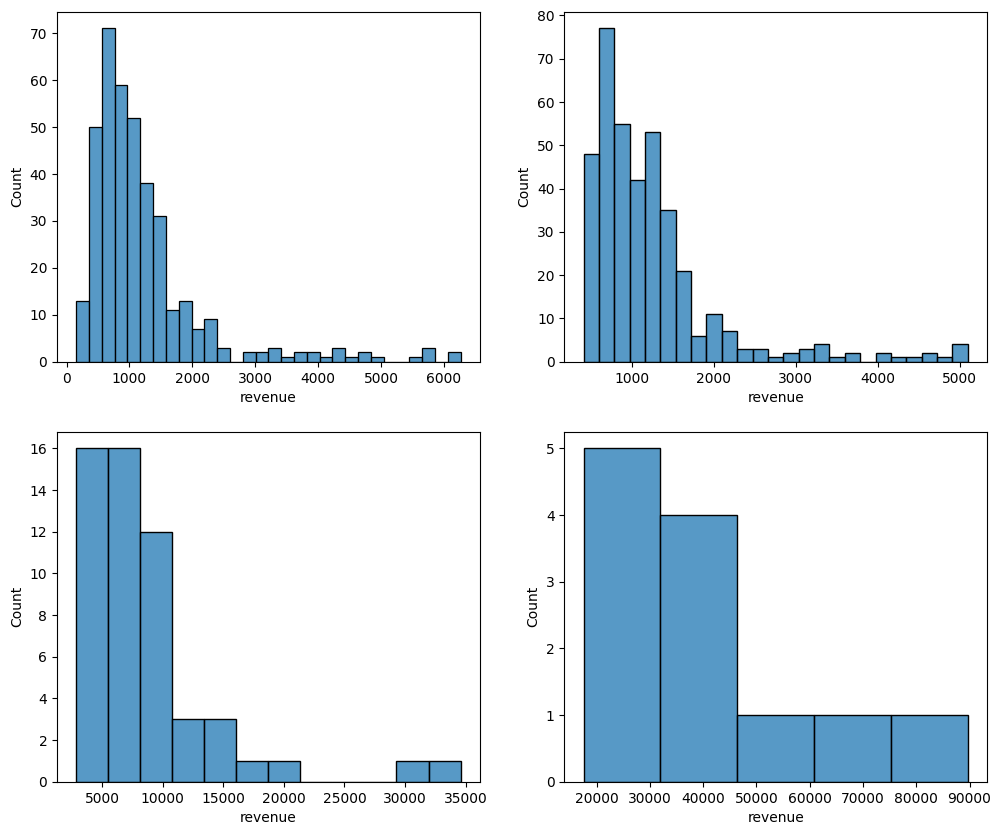

In [13]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
for i, granularity in enumerate(["daily", "rolling_avg", "weekly", "monthly"]):
    sns.histplot(dict_granularity[granularity]["revenue"],
                ax=ax[i//2][i%2])

## 3). 3). STL decomposition

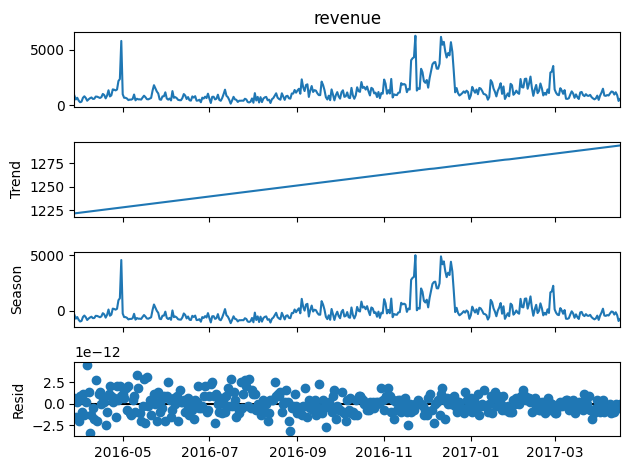

In [14]:
stl = STL(dict_granularity["daily"]["revenue"].dropna(how="any"),
         period=dict_periods["daily"])
result=stl.fit()
result.plot()
plt.tight_layout()

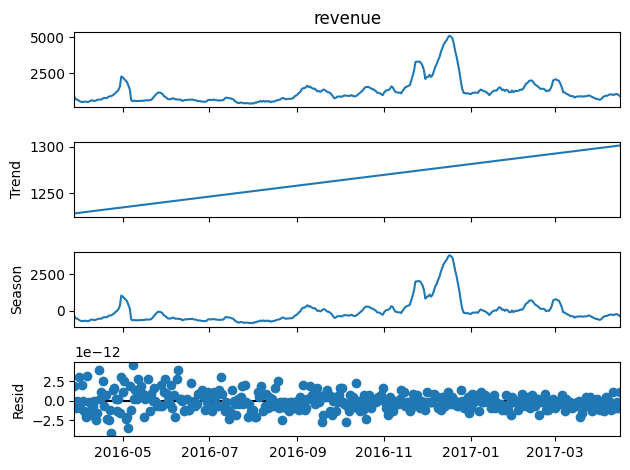

In [15]:
stl = STL(dict_granularity["rolling_avg"]["revenue"],
         period=dict_periods["rolling_avg"])
result=stl.fit()
result.plot()
plt.tight_layout()

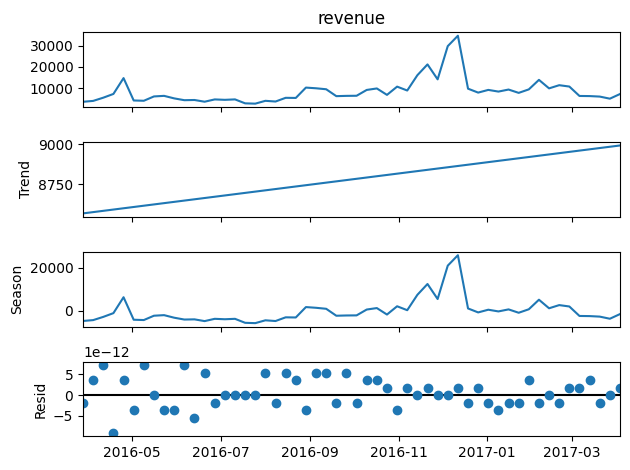

In [16]:
stl = STL(dict_granularity["weekly"]["revenue"],
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

We choose weekly data or rolling average for findings trends and seasonality as its a tradeoff between smoothing week days vs. week ends dynamics and noise and giving more data points than monthly data that has for 1.5 years too few noise

## 3). 4). Weekly evolutions

<Axes: xlabel='datetime'>

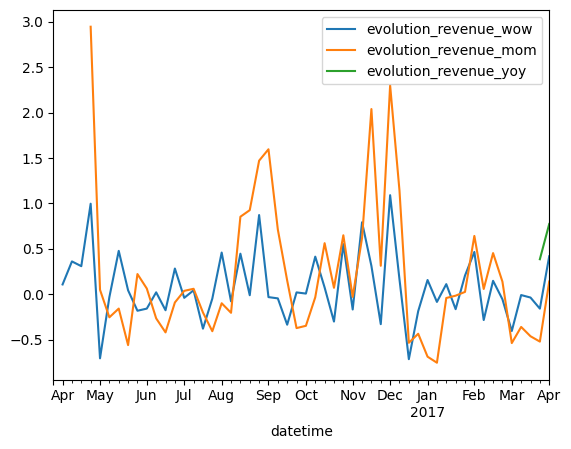

In [17]:
df_revenues_weekly["evolution_revenue_wow"]  =(
    df_revenues_weekly["revenue"].pct_change()
)

df_revenues_weekly["evolution_revenue_mom"]  =(
    df_revenues_weekly["revenue"].pct_change(periods=4)
)

df_revenues_weekly["evolution_revenue_yoy"]  =(
    df_revenues_weekly["revenue"].pct_change(periods=52)
)

df_revenues_weekly[["evolution_revenue_wow",
                   "evolution_revenue_mom",
                   "evolution_revenue_yoy"]].plot()

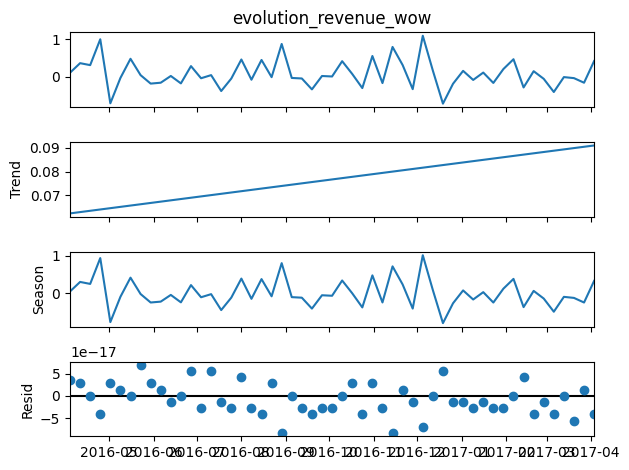

In [18]:
stl = STL(df_revenues_weekly["evolution_revenue_wow"].dropna(how="any"),
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

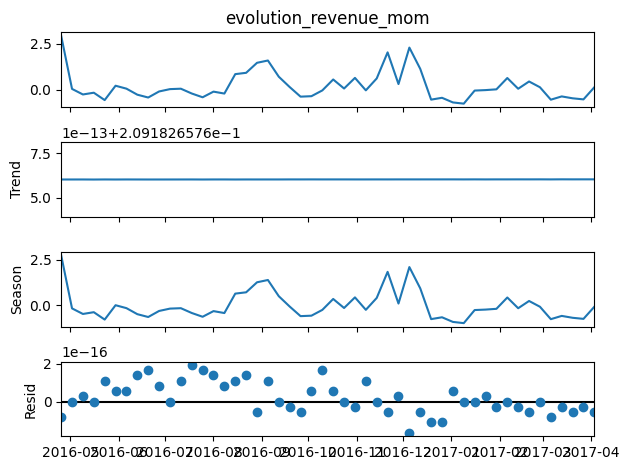

In [19]:
stl = STL(df_revenues_weekly["evolution_revenue_mom"].dropna(how="any"),
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

In [20]:
print(f"Average WoW rate: {average_rate(df_revenues_weekly["evolution_revenue_wow"].dropna())*100} %")
print(f"Average MoM rate: {average_rate(df_revenues_weekly["evolution_revenue_mom"].dropna())*100} %")

Average WoW rate: 7.956564185197634 %
Average MoM rate: 9.059415030111717 %


<Axes: xlabel='evolution_revenue_mom', ylabel='Count'>

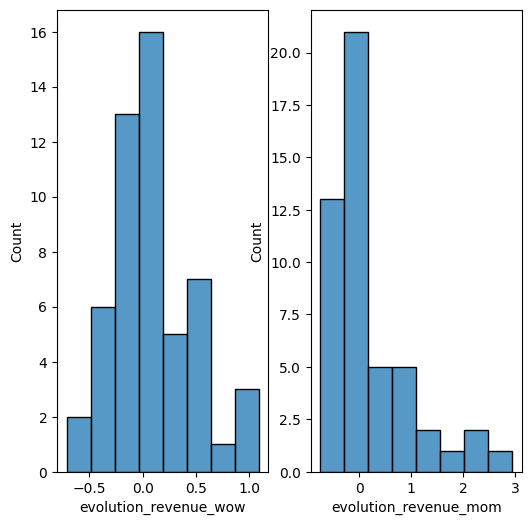

In [21]:
fig, ax = plt.subplots(1,2,figsize=(6,6))

sns.histplot(df_revenues_weekly["evolution_revenue_wow"], ax=ax[0])
sns.histplot(df_revenues_weekly["evolution_revenue_mom"], ax=ax[1])

## 3). 5). Contributions to the monthly evolutions

In [22]:
df_contrib = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_contrib["revenue"] = (
    df_contrib["price"] * 
    df_contrib["quantity"]
)

df_contrib["datetime"] = df_contrib["datetime"].dt.date

df_contrib = (
    df_contrib[["datetime", "revenue", "User location", "Device type", "Browser family", 
               "Environment", "Product category", "Existing client"]]
)

dict_contrib = {}

for col in ["User location", "Device type", "Browser family", "Environment",
           "Product category", "Existing client"]:
    dict_contrib[col] = (
        df_contrib.pivot_table(
            index="datetime",
            values="revenue",
            columns=col,
            aggfunc="sum"
        ).add_prefix(f"{col}_")
    )

    dict_contrib[col].index = (
        pd.to_datetime(dict_contrib[col].index)
    )


    dict_contrib[col] = (
        dict_contrib[col].resample("MS").sum()
    )

# We merge the different ventilations to get contributions
df_contrib_all = (
reduce(lambda left, right: pd.merge(left,
                                   right,
                                   left_index=True,
                                   right_index=True,
                                   how="outer"),
      list(dict_contrib.values()))
)

df_contrib = df_contrib[["datetime", "revenue"]].set_index("datetime")
df_contrib.index = pd.to_datetime(df_contrib.index)
df_contrib = df_contrib.resample("MS").sum()
df_contrib = df_contrib.iloc[1:-1]

df_contrib_all = (
    df_contrib_all.merge(df_contrib,
                        left_index=True,
                        right_index=True,
                        how="outer")
)

#We compute the contributions
for col in ["User location", "Device type", "Browser family", 
            "Environment","Product category", "Existing client"]:
    for col_ in [_ for _ in df_contrib_all.columns
                if _.startswith(col)]:

        df_contrib_all[f"contrib_{col_}"] = (
            df_contrib_all[col_].shift(1)/df_contrib_all["revenue"].shift(1)
            *df_contrib_all[col_].pct_change()
        )

df_contrib_all["evolution_revenue"] = (
    df_contrib_all["revenue"].pct_change()
)

df_contrib_all = (
    df_contrib_all[[col for col in df_contrib_all.columns
                   if col.startswith("contrib_") or col.startswith("evolution_")]]
)

df_contrib_all.head()

/tmp/ipykernel_6229/4174735641.py:73: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_contrib_all["revenue"].pct_change()


,contrib_User location_Inland,contrib_User location_Outside,contrib_User location_Unknown,contrib_Device type_Android - Smartphone,contrib_Device type_Android - Tablet,contrib_Device type_Desktop,contrib_Device type_Mobile - Other,contrib_Device type_Unknown,contrib_Device type_iPad,contrib_Device type_iPhone,contrib_Browser family_applemail,contrib_Browser family_blackberry webkit,contrib_Browser family_chrome,contrib_Browser family_chrome mobile,contrib_Browser family_chrome mobile ios,contrib_Browser family_chromium,contrib_Browser family_edge,contrib_Browser family_edge mobile,contrib_Browser family_facebook,contrib_Browser family_firefox,contrib_Browser family_firefox mobile,contrib_Browser family_ie,contrib_Browser family_ie mobile,contrib_Browser family_iron,contrib_Browser family_maxthon,contrib_Browser family_mobile safari,contrib_Browser family_mobile safari uiwebview,contrib_Browser family_opera,contrib_Browser family_other,contrib_Browser family_safari,contrib_Browser family_sleipnir,contrib_Browser family_unknown,contrib_Environment_app_android,contrib_Environment_web,contrib_Product category_Large Items,contrib_Product category_Medium Items,contrib_Product category_Packages,contrib_Product category_Small Items,contrib_Existing client_0,contrib_Existing client_1,evolution_revenue
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,-0.258470,0.004404,-0.000554,-0.002864,-0.000370,-0.278182,0.023716,NaN,0.001294,0.001786,NaN,NaN,-0.049526,-0.002803,0.000277,NaN,0.002310,NaN,NaN,-0.074627,NaN,-0.023500,-0.000339,NaN,NaN,0.002803,NaN,-0.001786,NaN,-0.109400,NaN,-0.004497,NaN,-0.254620,-0.018449,0.082512,-0.219816,-0.098867,-0.048509,-0.206111,-0.254620
2016-06-01,-0.158795,-0.035288,NaN,-0.000455,0.001405,-0.165902,-0.030949,NaN,-0.003140,0.004958,NaN,NaN,-0.107020,-0.000537,-0.001364,0.001777,0.004793,NaN,0.000578,-0.071071,NaN,-0.006281,NaN,NaN,-0.003223,0.003182,NaN,0.000537,NaN,-0.009628,-0.004793,-0.000661,NaN,-0.194083,-0.041155,-0.122598,-0.001446,-0.028883,-0.167762,-0.026321,-0.194083
2016-07-01,-0.121719,0.021637,NaN,-0.006409,-0.004973,-0.080650,-0.000820,NaN,-0.009178,0.001948,NaN,NaN,-0.069678,-0.006409,0.001743,-0.002051,-0.006717,NaN,-0.000820,0.021688,NaN,-0.021790,NaN,NaN,NaN,-0.010459,NaN,-0.001282,NaN,-0.007691,NaN,0.001282,NaN,-0.100082,0.005691,-0.082240,0.004512,-0.028046,-0.072293,-0.027789,-0.100082


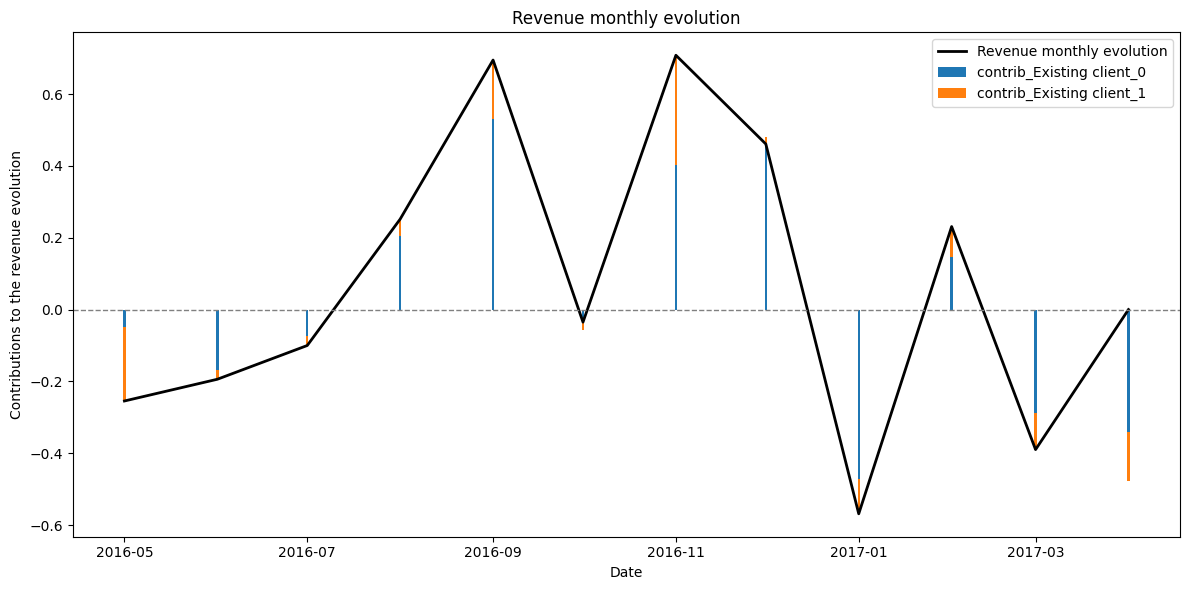

In [23]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Existing client")])

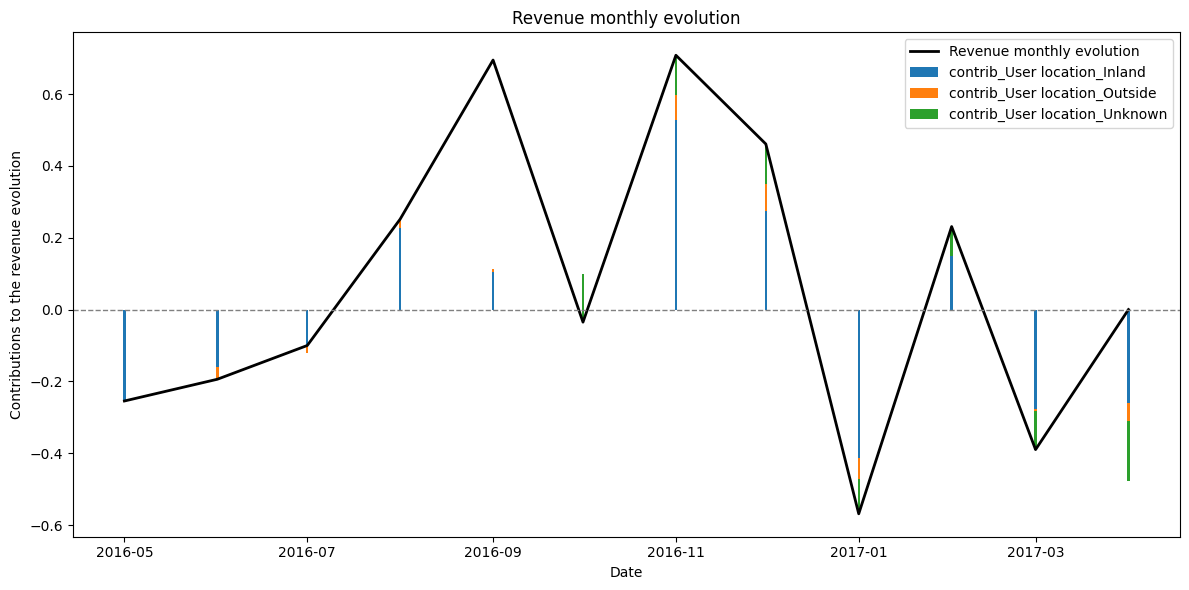

In [26]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_User location")])

# 4). Detection of outlier days

In [24]:
# Detection of outliers with zscores -> large skew we cannot use this technique
df_revenues["outlier_z_score"] = (
    np.abs((df_revenues["revenue"]-df_revenues["revenue"].mean())/
           df_revenues["revenue"].std()) > 3
)

# Detection of outliers with IQR
q1=df_revenues["revenue"].quantile(.25)
q3=df_revenues["revenue"].quantile(.75)
df_revenues["outlier_iqr"] = (
    (df_revenues["revenue"] < q1-1.5*(q3-q1))|(df_revenues["revenue"] > q3+1.5*(q3-q1))
)

# Detection of outliers with STL decomposition
df_revenues["stl_residuals"] = (
    STL(df_revenues["revenue"].dropna(how="any"),period=365).fit().resid
)
df_revenues["outlier_stl_residuals_z_score"] = (
    np.abs((df_revenues["stl_residuals"]-df_revenues["stl_residuals"].mean())/df_revenues["stl_residuals"].std()) > 3
)

df_revenues

,revenue,outlier_z_score,outlier_iqr,stl_residuals,outlier_stl_residuals_z_score
datetime,,,,,
2016-03-28,871.0,False,False,6.821210e-13,False
2016-03-29,533.0,False,False,-1.591616e-12,False
2016-03-30,682.0,False,False,2.273737e-13,False
2016-03-31,431.0,False,False,-2.046363e-12,False
2016-04-01,282.0,False,False,9.094947e-13,False
...,...,...,...,...,...
2017-04-12,974.0,False,False,-9.094947e-13,False
2017-04-13,1179.0,False,False,0.000000e+00,False
2017-04-14,922.0,False,False,-4.547474e-13,False


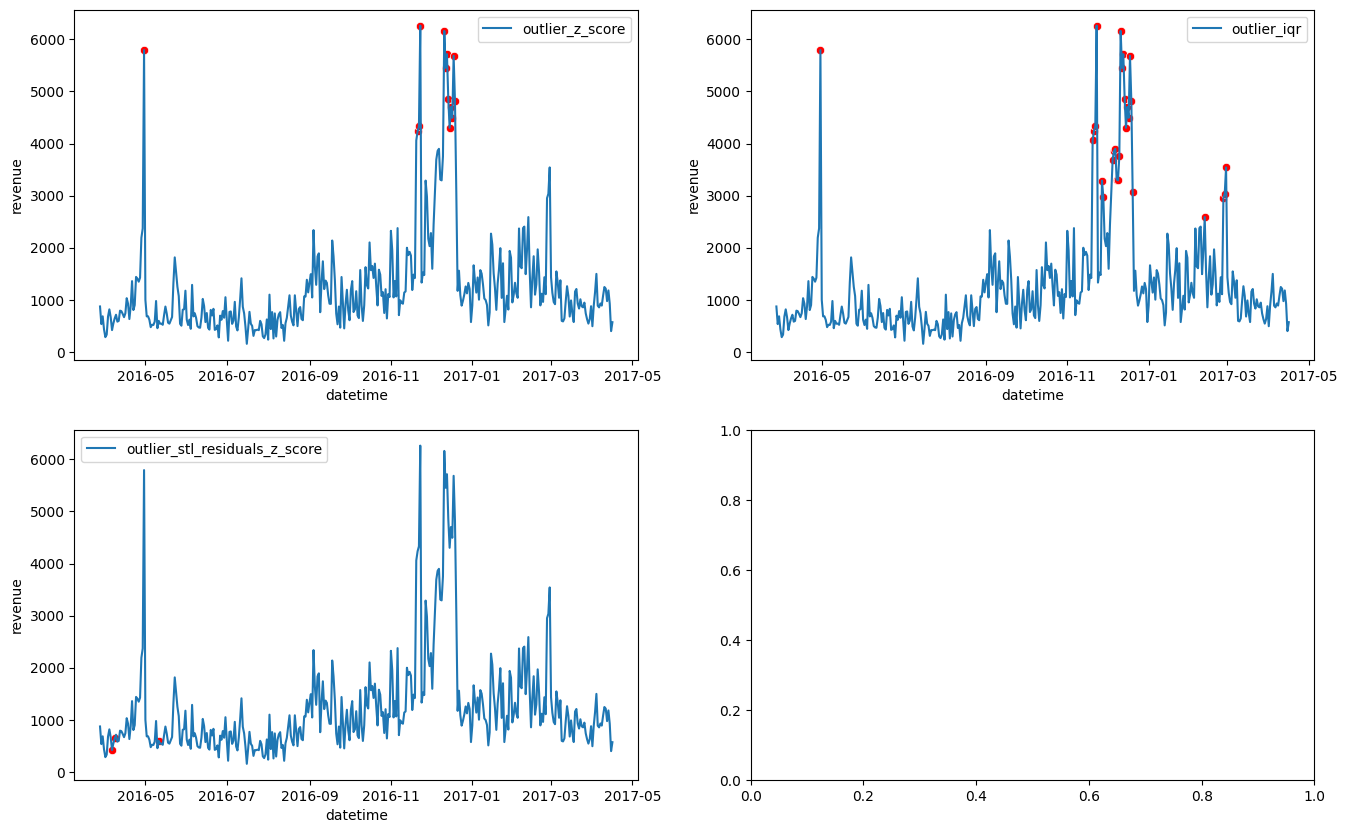

In [25]:
fig, axes = plt.subplots(2,2,figsize=(16,10))
axes = axes.flatten()

for i, outlier in enumerate(["outlier_z_score",
                            "outlier_iqr",
                            "outlier_stl_residuals_z_score"]):

    sns.lineplot(df_revenues, x=df_revenues.index, y="revenue",ax=axes[i],
                label=outlier)
    sns.scatterplot(
        data=df_revenues[df_revenues[outlier]],
        x=df_revenues[df_revenues[outlier]].index,
        y="revenue",
        color="red",
        ax=axes[i]
    )